In [1]:
#Step 1: Set up the environment

# import spacec first
import spacec as sp
# import standard packages

import glob
import os
import re
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sc.settings.set_figure_params(dpi=80, facecolor='white') 
# set the default color map to viridis, the below paramters can be chanaged
matplotlib.rcParams["image.cmap"] = 'viridis'

# Specify the path to the data
root_path = "/homes/zhanyx3/PTPN2_phenocycler/" # replace with your path
data_path = root_path + 'Images/' # where the data is stored

# where you want to store the output
output_dir = root_path + 'Yao/output/'
os.makedirs(output_dir, exist_ok=True)


/homes/zhanyx3/miniconda3/envs/spacec/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
2025-10-22 19:05:34.461826: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/4.3.1/lib/R/lib:/.singularity.d/libs:/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
2025-10-22 19:05:34.461845: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


M20-431_2203_HNSCC
(418909, 73)


/tmp/ipykernel_4162443/3129442401.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(['area', 'DAPI'])


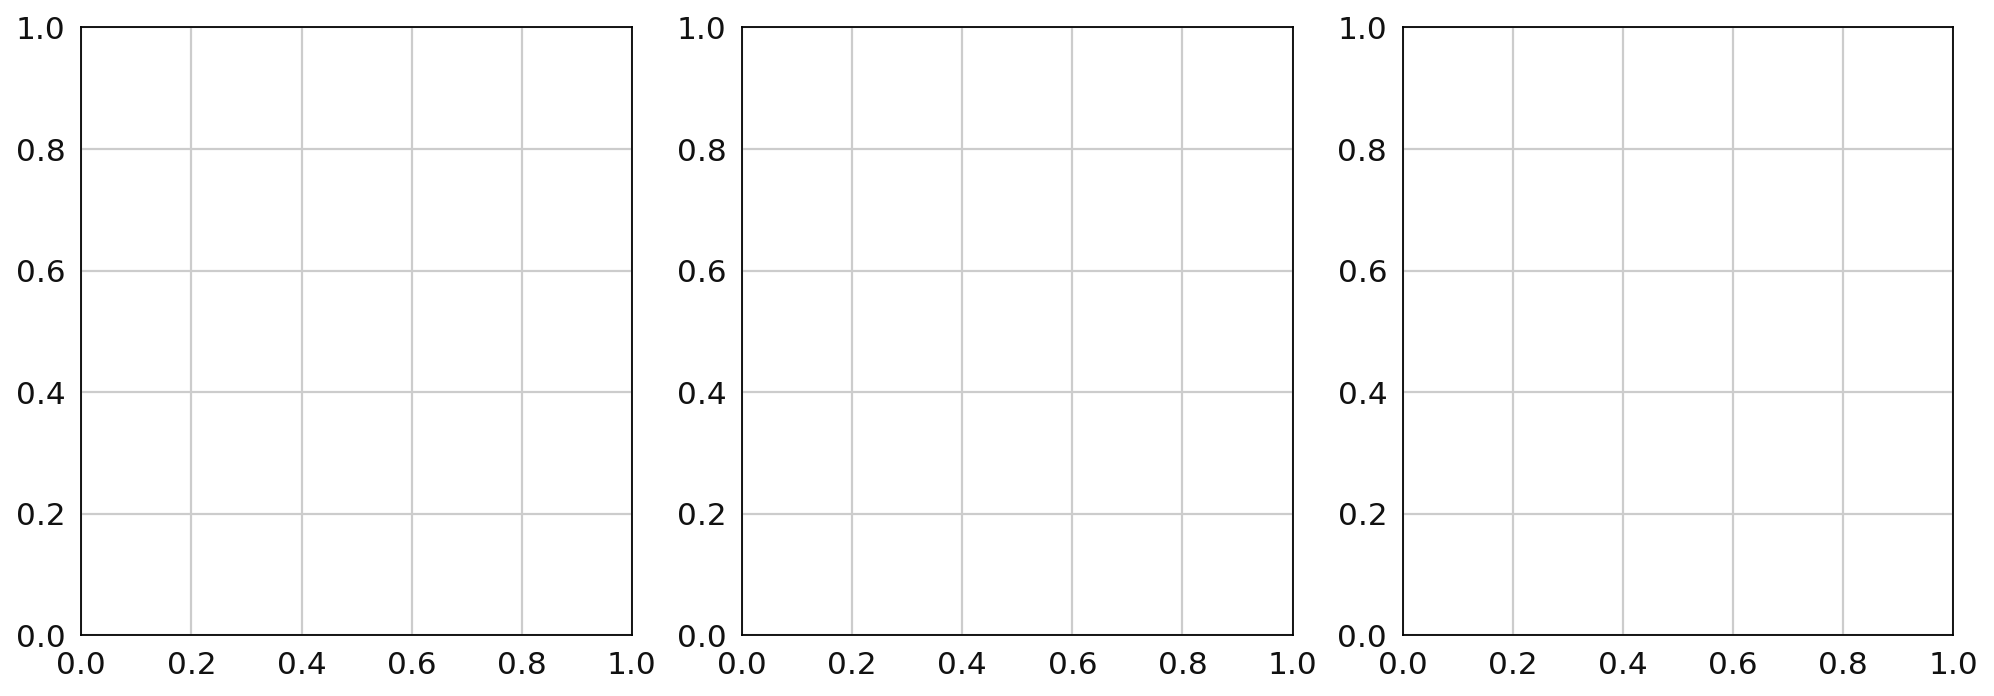

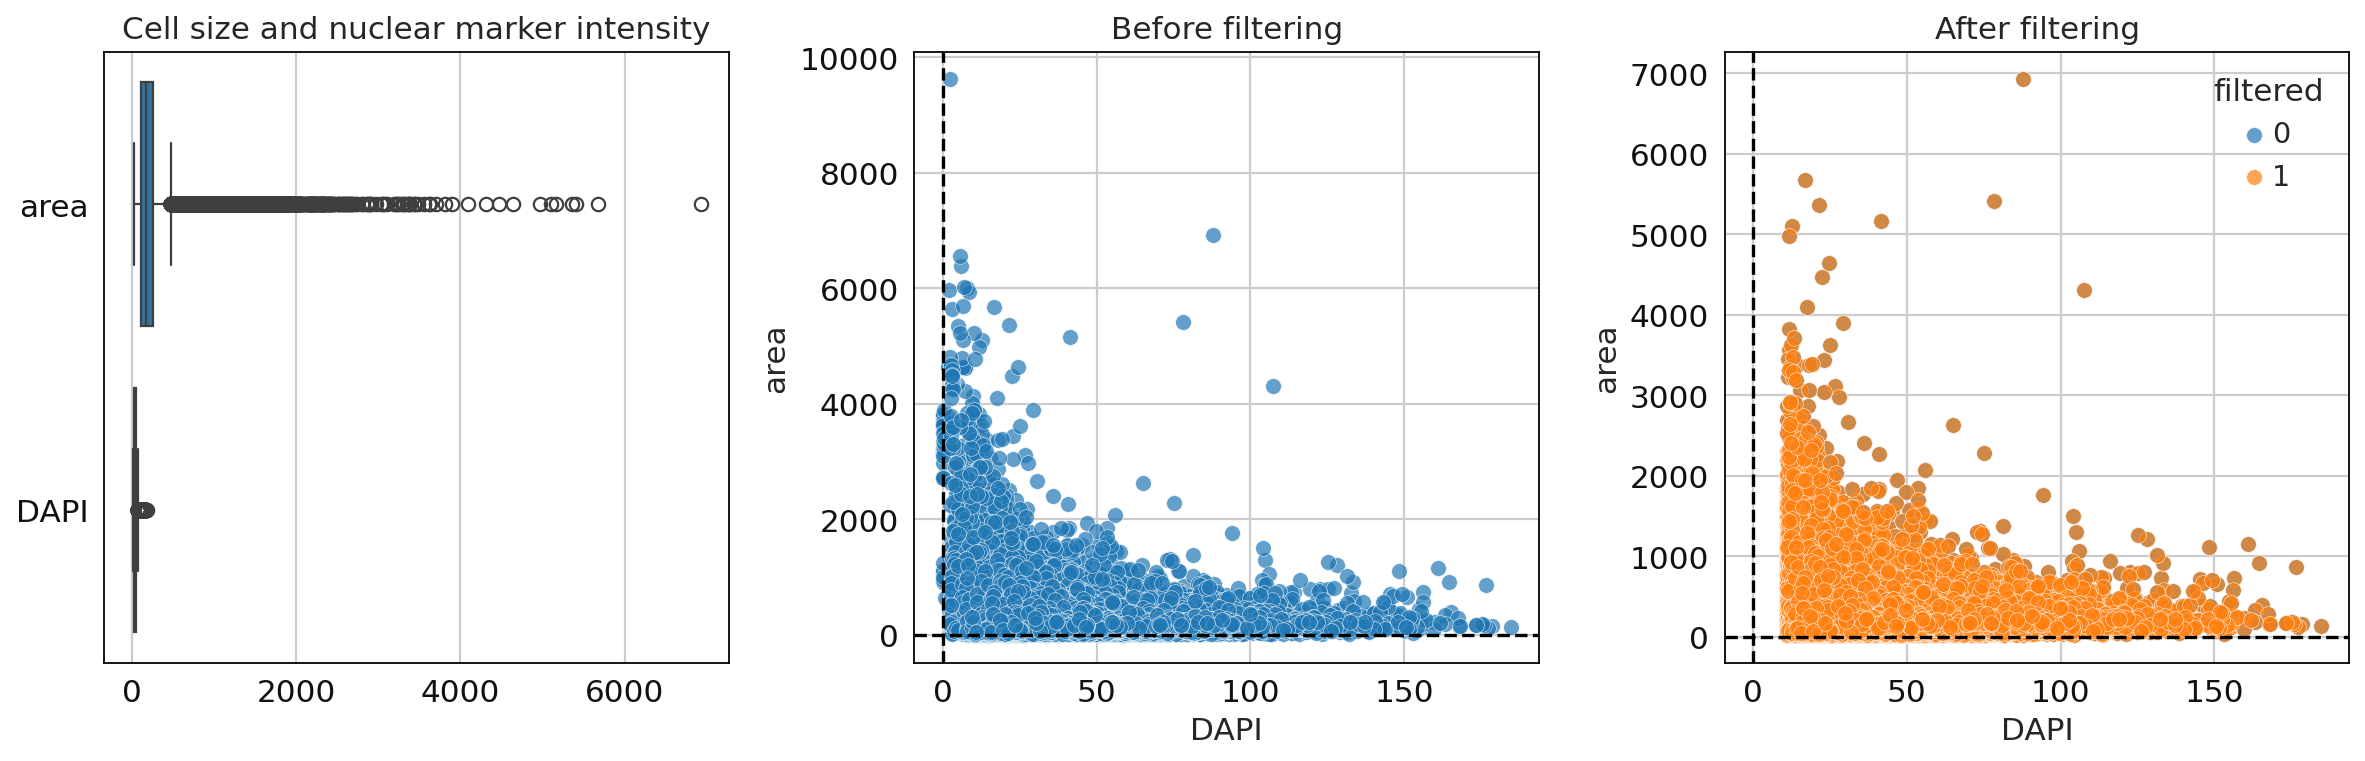

60
M20-431_2203_HNSCC


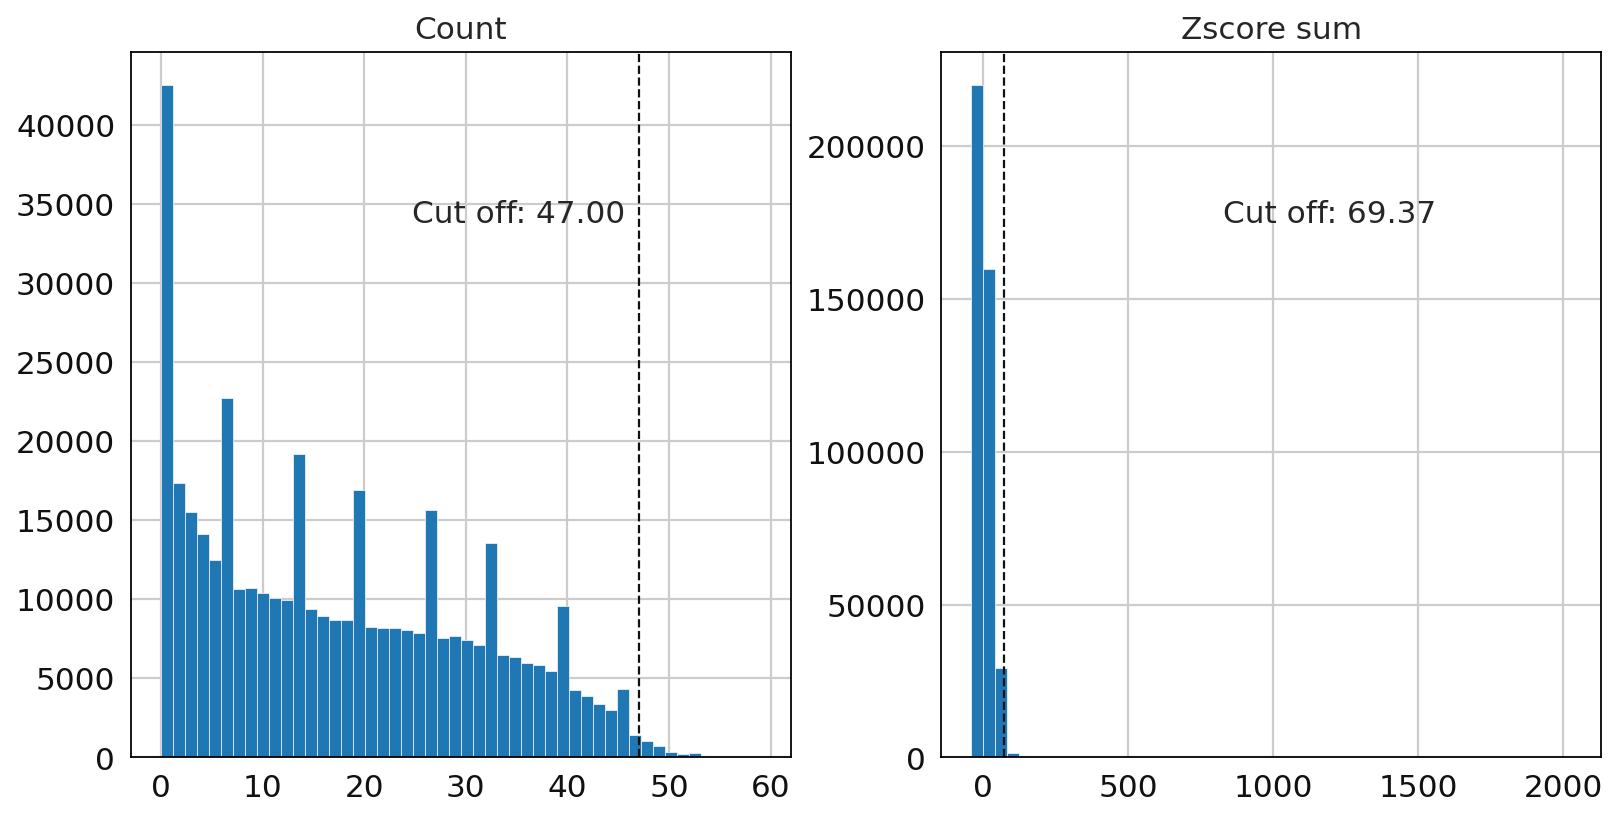

In [2]:
#C.1. Step 8: Load the segmented results. Segmented csv

# List all .txt files in the current directory
segment_files = glob.glob("/homes/zhanyx3/PTPN2_phenocycler/Yao/output/*_features.csv")

#################################################
## load first segmentation file first
#################################################

file = segment_files[3]

samplename = os.path.basename(file).replace('_features.csv', '')
    
print(samplename)

#read in segmentation csv files
#Read and concatenate the csv files (outputs from the cell segmentation algorithms). 
df_seg = sp.pp.read_segdf(
    segfile_list = [ # list of segmented files
        file
    ],
    seg_method = 'mesmer',
    region_list =[samplename],
    meta_list = [samplename]
)

#Get the shape of the data
print(df_seg.shape)

#See what it looks like
df_seg.head()

#C.2. Step 9: Initial removal of artifacts and debris. Filter cells by DAPI intensity and area

# If necessary filter the dataframe to remove too small objects or cells without a nucleus. 
# Identify the lowest 1% for cell size and nuclear marker intensity to get a better idea of potential segmentation artifacts.
df_filt = sp.pp.filter_data(
    df_seg, 
    nuc_thres=np.percentile(df_seg.DAPI, 1), # remove cells with DAPI intensity below threshold
    size_thres=np.percentile(df_seg.area, 1), # remove cells with area below threshold
    nuc_marker="DAPI", # name of nuclear marker
    cell_size = "area", # name of cell size column
    region_column = "condition", # column with region numbers
    color_by = "condition", # color by region number
    log_scale=False) # log scale for size

fig, axes = plt.subplots(1, 3, figsize=(15,5))

# 1. Boxplots for Area and DAPI
sns.boxplot(data=df_filt[['area', 'DAPI']], orient='h', ax=axes[0])
axes[0].set_yticklabels(['area', 'DAPI'])
axes[0].set_title('Cell size and nuclear marker intensity')

# 2. Scatter plot before filtering
axes[1].scatter(df_seg['DAPI'], df_seg['area'], s=50, alpha=0.7, edgecolor='w')
axes[1].set_xlabel('DAPI')
axes[1].set_ylabel('area')
axes[1].set_title('Before filtering')
axes[1].axhline(0, linestyle='dashed', color='black')
axes[1].axvline(0, linestyle='dashed', color='black')

# 3. Scatter plot after filtering
for val in [0, 1]:
    subset = df_filt
    axes[2].scatter(subset['DAPI'], subset['area'], label=val, alpha=0.7, s=50, edgecolor='w')
axes[2].set_xlabel('DAPI')
axes[2].set_ylabel('area')
axes[2].set_title('After filtering')
axes[2].legend(title='filtered')
axes[2].axhline(0, linestyle='dashed', color='black')
axes[2].axvline(0, linestyle='dashed', color='black')

plt.tight_layout()
plt.show()

# C.3. Step 10: Normalize data. # Normalize data with one of the four available methods (zscore as default)
df_filt.columns
# This is to normalize the data per region/tif
dfz = pd.DataFrame()

for region in df_filt.unique_region.unique():
    df_reg = df_filt[df_filt.unique_region == region]
    df_reg_norm = sp.pp.format(
        data=df_reg, 
        list_out= ['eccentricity', 'perimeter', 'convex_area', 'axis_major_length', 'axis_minor_length'], # list of features to remove
        list_keep = ["DAPI",'x','y', 'area','region_num',"unique_region", 'condition'], # list of meta information that you would like to keep but don't want to normalize
        method = "zscore") # choose from "zscore", "double_zscore", "MinMax", "ArcSin"
    dfz = pd.concat([dfz,df_reg_norm], axis = 0)

dfz.shape

dfz.columns

# get the column index for the last marker 
#col_num_last_marker = dfz.columns.get_loc('CD31_2')
col_num_last_marker = dfz.shape[1] - (7 + 1) # get column size, minus 7 list keep columns and minus 1 for counting starting from 0 in python
print(col_num_last_marker)

# This function helps to figure out what the cut-off should be for each region
for region in dfz.unique_region.unique():
    print(region)
    df_reg = dfz[dfz.unique_region == region]
    sp.pl.zcount_thres(dfz = df_reg, 
                col_num = col_num_last_marker, # last antibody index
                cut_off=0.01, #top 1% of cells
                count_bin=50)

In [3]:
# This is to remove top 1 % of all cells that are highly expressive for all antibodies
df_nn = pd.DataFrame()
cutoff_list = [[47,69.37]]

for i in range(len(dfz.unique_region.unique())):
    df_reg = dfz[dfz.unique_region == dfz.unique_region.unique()[i]]
    df_reg_nn,cc = sp.pp.remove_noise(
        df=df_reg, 
        col_num=col_num_last_marker, # this is the column index that has the last protein feature
        z_count_thres=cutoff_list[i][0], # number obtained from the function above
        z_sum_thres=cutoff_list[i][1] # number obtained from the function above
    )
    print(df_reg_nn.shape)
    df_nn = pd.concat([df_nn,df_reg_nn], axis = 0)
df_nn.shape

#Save the df as a backup. We strongly recommend the Anndata format for further analysis!
df_nn.to_csv(output_dir + "df_nn_" + samplename + ".csv")

# inspect which markers work, and drop the ones that did not work from the clustering step
# make an anndata to be compatible with the downstream clustering step
adata = sp.hf.make_anndata(
    df_nn = df_nn,
    col_sum = col_num_last_marker, # this is the column index that has the last protein feature # the rest will go into obs
    nonFuncAb_list = [] # Remove the antibodies that are not working from the clustering step
)
adata

# save the anndata object to a file
adata.write_h5ad(output_dir + 'adata_'+ samplename +'.h5ad')

1.3% cells are removed.
(405014, 68)


/homes/zhanyx3/miniconda3/envs/spacec/lib/python3.10/site-packages/spacec/preprocessing/_general.py:431: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_want.drop(columns=["Count", "z_sum"], inplace=True)
/homes/zhanyx3/miniconda3/envs/spacec/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
# D.1. Step 12: Cell-type annotation via clustering. 

# Loading the denoise/filtered anndata 
# adata = sc.read(output_dir + 'adata_nn_M20-124_30012-1_NSCLC.h5ad')
# adata # check the adata

#By setting a clustering seed you can ensure that your PC is always performing clustering in the same way
clustering_random_seed = 0

# This step can be long if you have large phenocycler images

# Use this cell-type specific markers for cell type annotation
marker_list = list(adata.var_names)

# clustering
adata = sp.tl.clustering(
    adata, 
    clustering='leiden', # can choose between leiden and louvian
    n_neighbors=50, # number of neighbors for the knn graph
    resolution=0.5, #clustering resolution (higher resolution gives more clusters)
    reclustering = False, # if true, no computing the neighbors
    marker_list = None, #if it is None, all variable names are used for clustering
    seed=clustering_random_seed, # random seed for clustering - reproducibility
)


In [ ]:
adata

In [ ]:
adata
# visualization of clustering with UMAP
sc.pl.umap(adata, color = ['leiden_1', 'unique_region'], wspace=0.5) 

sc.pl.dotplot(adata, 
              marker_list, # The list of markers to show on the x-axis
              'leiden_1', # The cluster column
              dendrogram = True) # Show the dendrogramsamplename

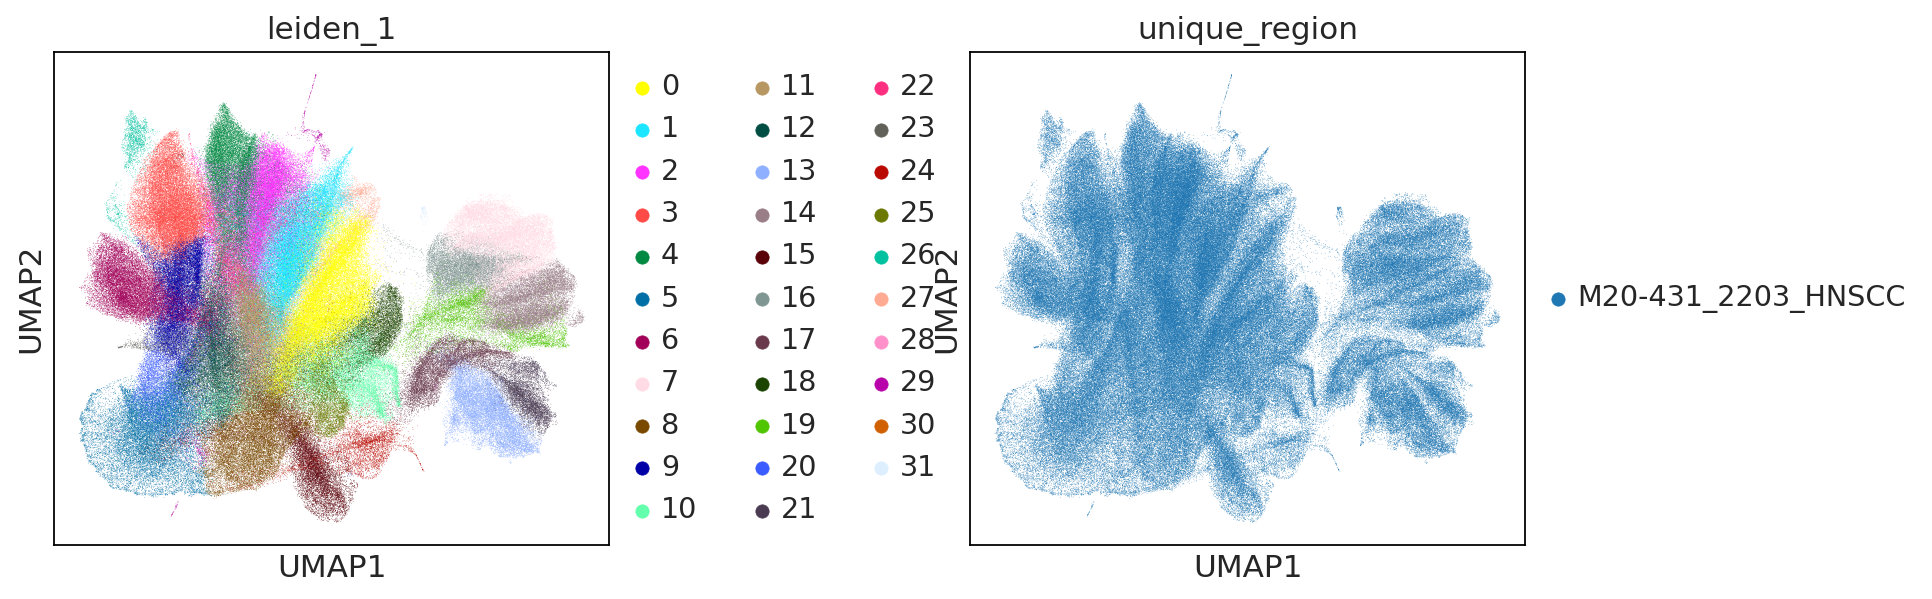

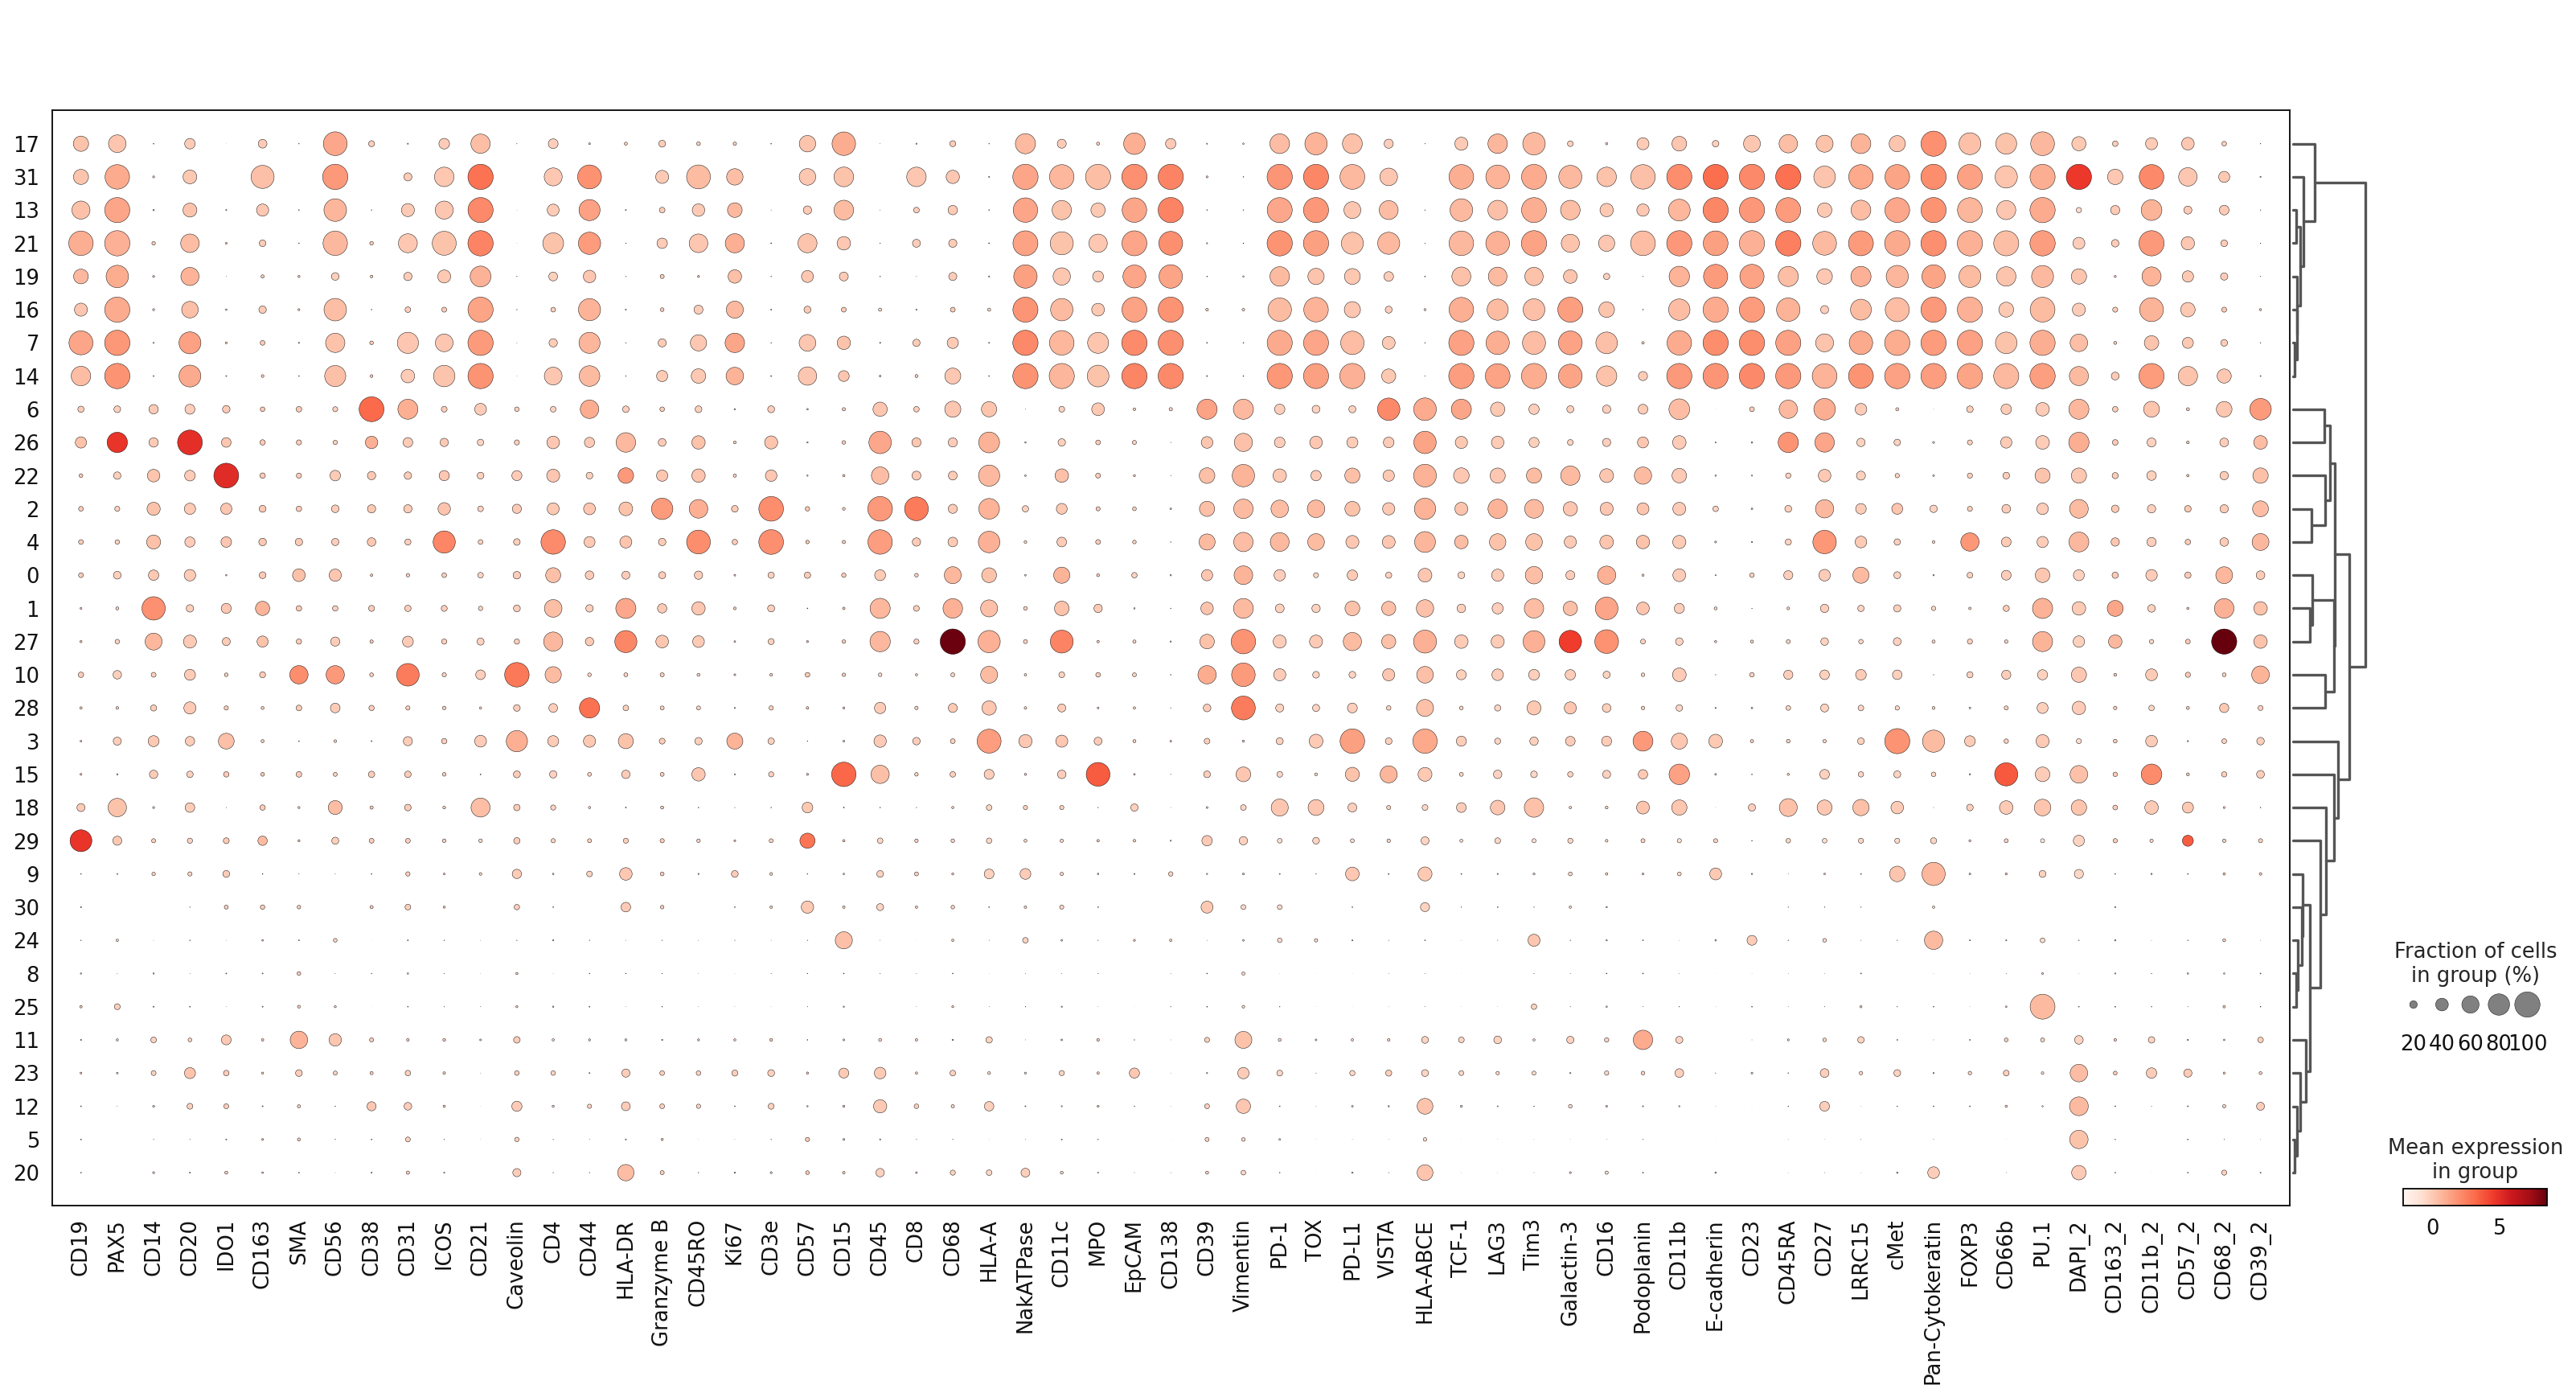

In [6]:
# visualization of clustering with UMAP
sc.pl.umap(adata, color = ['leiden_1', 'unique_region'], wspace=0.5) 

sc.pl.dotplot(adata, 
              marker_list, # The list of markers to show on the x-axis
              'leiden_1', # The cluster column
              dendrogram = True) # Show the dendrogram

In [7]:
# store the annotated adata
adata.write(output_dir + "adata_" + samplename + "_annotated.h5ad")

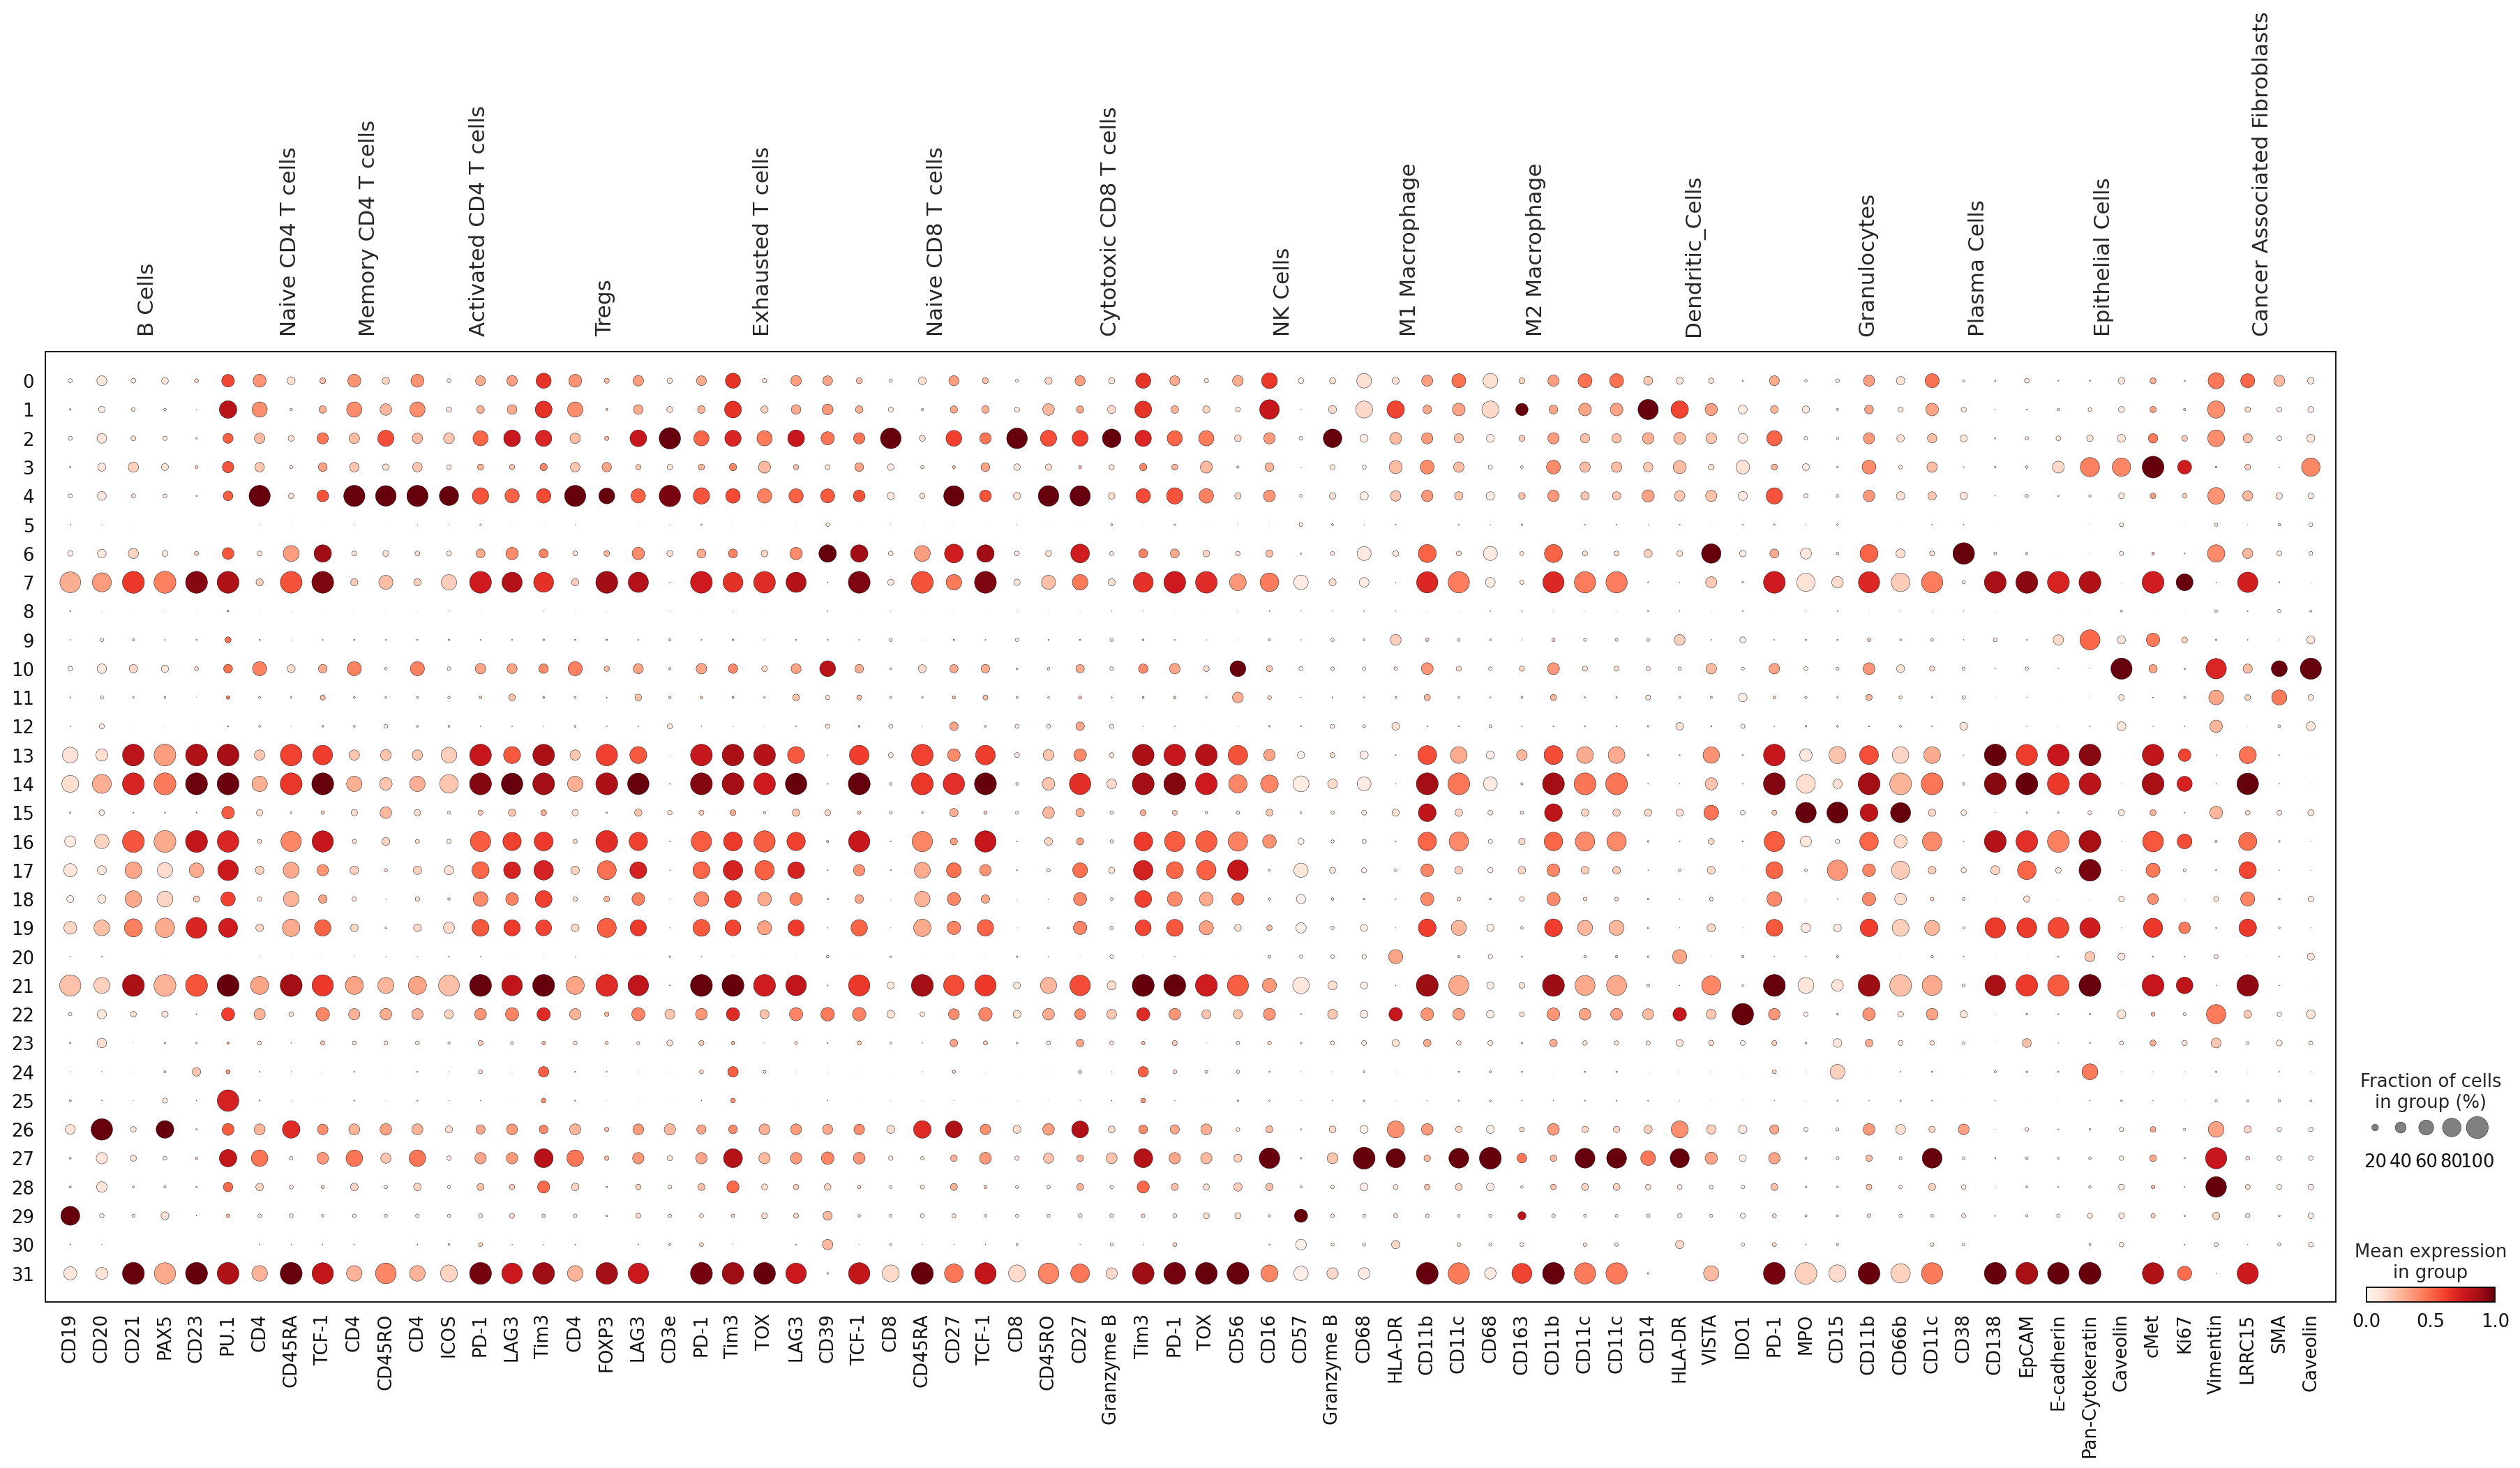

In [10]:
marker_genes = {
    "B Cells": ["CD19", "CD20", "CD21", "PAX5", "CD23", "PU.1"],
    "Naive CD4 T cells": ["CD4", "CD45RA", "TCF-1"],
    "Memory CD4 T cells": ["CD4", "CD45RO"],
    "Activated CD4 T cells": ["CD4", "ICOS", "PD-1", "LAG3", "Tim3"],
    "Tregs": ["CD4", "FOXP3", "LAG3"],
    "Exhausted T cells": ["CD3e", "PD-1", "Tim3", "TOX", "LAG3", "CD39", "TCF-1"],
    "Naive CD8 T cells": ["CD8", "CD45RA", "CD27", "TCF-1"],
    "Cytotoxic CD8 T cells": ["CD8", "CD45RO", "CD27", "Granzyme B", "Tim3", "PD-1", "TOX"],
    "NK Cells": ["CD56","CD16", "CD57","Granzyme B"],
    "M1 Macrophage": ["CD68", "HLA-DR", "CD11b", "CD11c"],
    "M2 Macrophage": ["CD68", "CD163", "CD11b", "CD11c"],
    "Dendritic_Cells": ["CD11c", "CD14", "HLA-DR", "VISTA", "IDO1", "PD-1"],
    "Granulocytes": ["MPO", "CD15", "CD11b", "CD66b", "CD11c"],
    "Plasma Cells": ["CD38", "CD138"],
    "Epithelial Cells": ["EpCAM", "E-cadherin", "Pan-Cytokeratin", "Caveolin", "cMet", 
                         "Ki67"],
    "Cancer Associated Fibroblasts": ["Vimentin", "LRRC15", "SMA", "Caveolin"],
}

sc.pl.dotplot(adata, marker_genes, groupby="leiden_1", standard_scale="var")

In [ ]:
# tentative annotation based on the marker 
cluster_to_ct_dict = {
    '0,0': 'B cell', 
    '0,1': 'recluster', 
    '0,2': 'B cell', 
    '1,0': 'recluster',
    '1,1': 'recluster',
    '1,2': 'recluster',
    '1,3': 'recluster',
    '1,4': 'recluster',
    '2': 'B cell', 
    '3,0': 'DC', 
    '3,1': 'DC', 
    '3,2': 'M1 Macrophage', 
    '4': 'CD4+ T cell', 
    '5': 'Epithelial cell',
    '6': 'CD8+ T cell',
    '7,0': 'B cell',
    '7,1': 'recluster',
    '7,2': 'B cell',
    '8': 'GCB',
    '9': 'Plasma cell',
    '10': 'Vessel',
    '11,0': 'B cell',  
    '11,1': 'B cell',  
    '11,2': 'B cell',  
    '11,3': 'B cell',  
    '12,0': 'CD4+ T cell',
    '12,1': 'CD4+ T cell',
    '12,2': 'CD4+ T cell',
    '12,3': 'DC',
    '12,4': 'DC',
    '13': 'B cell',
    '14,0': 'Noise',
    '14,1': 'Noise',
    '14,2': 'Noise',
    '14,3': 'Noise',
    '14,4': 'Noise',
    '14,5': 'Noise',
    '15': 'M2 Macrophage',
    '16,0': 'Treg',
    '16,1': 'Treg',
    '16,2': 'CD4+ T cell',
    '16,3': 'Treg',
    '16,4': 'CD4+ T cell',
    '16,5': 'Treg',
    '17,0': 'recluster',
    '17,1': 'recluster',
    '17,2': 'recluster',
    '17,3': 'recluster',
    '17,4': 'recluster',
    '18': 'cDC1',
    '19': 'M1 Macrophage',
    '20,0': 'Epithelial cell',
    '20,1': 'Epithelial cell',
    '20,2': 'Epithelial cell',
    '20,3': 'Epithelial cell',
    '20,4': 'recluster',
    '21': 'Epithelial cell',
    '22': 'Mast cell',
    '23': 'NK cell',
}

# This allows us to generate a new column named cell_type_coarse based on the leiden_1_subcluster column
adata.obs['cell_type_coarse'] = ( # create a new column
    adata.obs['leiden_1_subcluster'] # get the cluster names
    .map(cluster_to_ct_dict) # map the cluster names to cell types
    .astype('category') # convert to category
)

# store the annotated adata
adata.write(output_dir + "adata_" + samplename + "_annotated.h5ad")

In [ ]:
# Check the marker expression of the annotated cell types
sc.pl.dotplot(adata, marker_list, 'cell_type_coarse', dendrogram = False)

# Plot the spatial distribution of cell types
sp.pl.catplot(
    adata = adata,
    color = "celltype",
    unique_region = "condition",
    X = ’x’,
    Y = ’y’)

## basic statistics

# Bar plot of cell type percentage
ct_perc_tab, _ = sp.pl.stacked_bar_plot(
    adata = adata,
    color = ’celltype’,
    grouping = ’condition’,
    cell_list = [’GCB’, ’Treg’])

# Pie chart for cell type percentage
sp.pl.create_pie_charts(
    adata = adata,
    color = "celltype",
    grouping = "condition",
    show_percentages = False)

In [ ]:
#Show the spatial distribution for size (Optional)

# import pickle
import re

with open(output_dir + 'overlay_' + re.sub(r'_NSCLC|_HNSCC', '', samplename) + '.pickle', 'rb') as f:
    overlay_data = pickle.load(f)

sp.pl.coordinates_on_image(
    df = df_nn, 
    overlay_data = overlay_data, color='area',  
    scale=False, # whether to scale to 1 or not
    dot_size=5,
    convert_to_grey=True, 
    fig_width=10, fig_height=10)

#This function can also be used to inspect where certain markers are expressed in the tissue.
import matplotlib.pyplot as plt
plt.rc('axes', grid=False)  # remove gridlines

marker_list = ['CD45', 'DAPI_2', 'Pan-Cytokeratin','CD38']

for marker in marker_list:
    sp.pl.coordinates_on_image(
        df = df_nn, 
        overlay_data = overlay_data, 
        color=marker, 
        scale=False, # whether to scale to 1 or not
        dot_size=2,
        convert_to_grey=True, 
        fig_width=10, fig_height=10 )